In [26]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./traffic-signs-data/train.p"
validation_file= "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_validation shape:", X_valid.shape)
print("y_validation shape:", y_valid.shape)
print("y_test shape:", X_test.shape)
print("x_test shape:", y_test.shape)

x_train shape: (34799, 32, 32, 3)
y_train shape: (34799,)
x_validation shape: (4410, 32, 32, 3)
y_validation shape: (4410,)
y_test shape: (12630, 32, 32, 3)
x_test shape: (12630,)


9


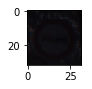

In [27]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(1, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

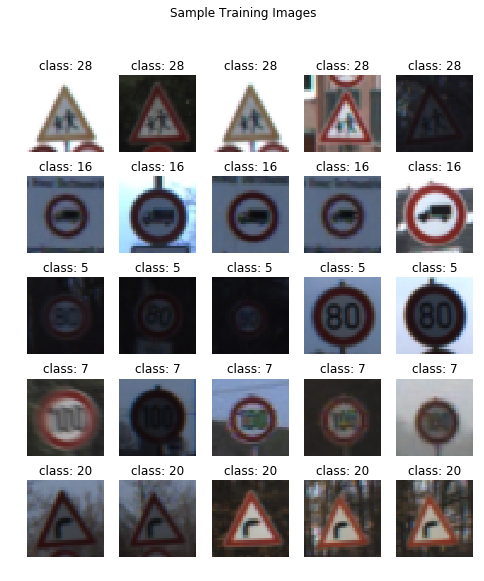

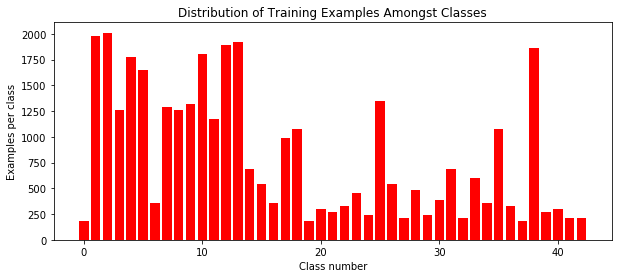

In [28]:
# Visualizations will be shown in the notebook.

def display_images(image_dataset, n_rows, n_cols, graph_title='Sample Training Images'):
    plt.figure(figsize=(8, 9))
    selected_classes = np.random.randint(44, size=n_rows)
    image_number = 1
    for row in selected_classes:
        for col in range(1, n_cols + 1):
            plt.subplot(n_rows, n_cols, image_number)
            image_number += 1
            x_selected = X_train[y_train == row]
            random_index = np.random.randint(x_selected.shape[0])
            plt.imshow(x_selected[random_index, :, :, :]) 
            plt.axis('off')
            plt.title('class: {}'.format(row))  
    plt.suptitle(graph_title)
    plt.show()
#This function is used to plot the distribution of training examples amongst classes.
def draw_class_distribution(class_labels):
    plt.figure(figsize=(10, 4))
    examples_per_class = np.bincount(class_labels)
    num_classes = len(examples_per_class)
    plt.bar(np.arange(num_classes), examples_per_class, 0.8, color='red', label='Inputs per class')
    plt.xlabel('Class number')
    plt.ylabel('Examples per class')
    plt.title('Distribution of Training Examples Amongst Classes')
    plt.show()   
    
display_images(X_train, 5, 5)
draw_class_distribution(y_train)

In [29]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Convert to grayscale
X_train_rgb = X_train
X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)

X_valid_rgb = X_valid
X_valid_gry = np.sum(X_valid/3, axis=3, keepdims=True)

X_test_rgb = X_test
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)

X_train = X_train_gry
X_valid = X_valid_gry
X_test = X_test_gry

In [30]:
## Normalize the train and test datasets to (-1,1)

X_train_normalized = (X_train - 128)/128 
X_valid_normalized = (X_valid - 128)/128
X_test_normalized = (X_test - 128)/128

print(np.mean(X_train_normalized))
print(np.mean(X_valid_normalized))
print(np.mean(X_test_normalized))

-0.354081335648
-0.347215411128
-0.358215153428


In [31]:
import cv2

def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

In [32]:
n_classes = len(np.unique(y_train))
print('X, y shapes:', X_train_normalized.shape, y_train.shape)

input_indices = []
output_indices = []

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 300:
        for i in range(300 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_train_normalized.shape[0])
            new_img = X_train_normalized[class_indices[0][i % n_samples]]
            new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
            X_train_normalized = np.concatenate((X_train_normalized, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('X, y shapes:', X_train_normalized.shape, y_train.shape)

X, y shapes: (34799, 32, 32, 1) (34799,)
0 : |----|----|-
1 : 
2 : 
3 : 
4 : 
5 : 
6 : 
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : 
15 : 
16 : 
17 : 
18 : 
19 : |----|----|-
20 : 
21 : |--
22 : 
23 : 
24 : |----|
25 : 
26 : 
27 : |----|---
28 : 
29 : |----|
30 : 
31 : 
32 : |----|---
33 : 
34 : 
35 : 
36 : 
37 : |----|----|-
38 : 
39 : |--
40 : 
41 : |----|---
42 : |----|---
X, y shapes: (35699, 32, 32, 1) (35699,)


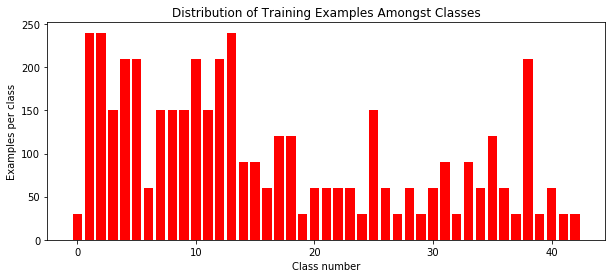

In [33]:
def draw_class_distribution(class_labels):
    plt.figure(figsize=(10, 4))
    examples_per_class = np.bincount(class_labels)
    num_classes = len(examples_per_class)
    plt.bar(np.arange(num_classes), examples_per_class, 0.8, color='red', label='Inputs per class')
    plt.xlabel('Class number')
    plt.ylabel('Examples per class')
    plt.title('Distribution of Training Examples Amongst Classes')
    plt.show()   
draw_class_distribution(y_valid)

In [34]:
n_classes_valid = len(np.unique(y_valid))
print('X, y shapes:', X_valid_normalized.shape, y_valid.shape)

input_indices = []
output_indices = []

for class_n in range(n_classes_valid):
    print(class_n, ': ', end='')
    class_indices = np.where(y_valid == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 70:
        for i in range(300 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_valid_normalized.shape[0])
            new_img = X_valid_normalized[class_indices[0][i % n_samples]]
            new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
            X_valid_normalized = np.concatenate((X_valid_normalized, [new_img]), axis=0)
            y_valid = np.concatenate((y_valid, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('X, y shapes:', X_valid_normalized.shape, y_valid.shape)

X, y shapes: (4410, 32, 32, 1) (4410,)
0 : |----|----|----|----|----|-
1 : 
2 : 
3 : 
4 : 
5 : 
6 : |----|----|----|----|---
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : 
15 : 
16 : |----|----|----|----|---
17 : 
18 : 
19 : |----|----|----|----|----|-
20 : |----|----|----|----|---
21 : |----|----|----|----|---
22 : |----|----|----|----|---
23 : |----|----|----|----|---
24 : |----|----|----|----|----|-
25 : 
26 : |----|----|----|----|---
27 : |----|----|----|----|----|-
28 : |----|----|----|----|---
29 : |----|----|----|----|----|-
30 : |----|----|----|----|---
31 : 
32 : |----|----|----|----|----|-
33 : 
34 : |----|----|----|----|---
35 : 
36 : |----|----|----|----|---
37 : |----|----|----|----|----|-
38 : 
39 : |----|----|----|----|----|-
40 : |----|----|----|----|---
41 : |----|----|----|----|----|-
42 : |----|----|----|----|----|-
X, y shapes: (9990, 32, 32, 1) (9990,)


In [35]:
## Shuffle the training dataset

from sklearn.utils import shuffle

X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
X_valid_normalized, y_valid = shuffle(X_valid_normalized, y_valid)
print("Old X_train size:",len(X_train))
print("New X_train size:",len(X_train_normalized))
print("Old X_validation size:",len(X_valid))
print("New X_validation size:",len(X_valid_normalized))
print("New X_test size:",len(X_test))

Old X_train size: 34799
New X_train size: 35699
Old X_validation size: 4410
New X_validation size: 9990
New X_test size: 12630


In [36]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 100

In [37]:
from sklearn.model_selection import train_test_split

X_train_split, X_validation_split, y_train_split, y_validation_split = train_test_split(X_train_normalized, y_train, 
                                                                test_size=0.20, random_state=42)

print("Old X_train size:",len(X_train_normalized))
print("New X_train size:",len(X_train_split))
print("X_validation size:",len(X_validation_split))

Old X_train size: 35699
New X_train size: 28559
X_validation size: 7140


In [38]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6))
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16))
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    b3 = tf.Variable(tf.zeros(120))    
    x = tf.add(tf.matmul(x, W3), b3)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros(84)) 
    x = tf.add(tf.matmul(x, W4), b4)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    W5 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros(43)) 
    logits = tf.add(tf.matmul(x, W5), b5)
    
    return logits


In [39]:
from tensorflow.contrib.layers import flatten

def LeNet2(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x
    
    # TODO: Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)
    layer3 = x

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    print("layer2flat shape:",layer2flat.get_shape())
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    print("xflat shape:",xflat.get_shape())
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat([xflat, layer2flat], 1)
    print("x shape:",x.get_shape())
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # TODO: Layer 4: Fully Connected. Input = 800. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    
    # TODO: Activation.
    #x = tf.nn.relu(x)

    # TODO: Layer 5: Fully Connected. Input = 120. Output = 84.
    #W5 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    #b5 = tf.Variable(tf.zeros(84)) 
    #x = tf.add(tf.matmul(x, W5), b5)
    
    # TODO: Activation.
    #x = tf.nn.relu(x)

    # TODO: Layer 6: Fully Connected. Input = 84. Output = 43.
    #W6 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    #b6 = tf.Variable(tf.zeros(43)) 
    #logits = tf.add(tf.matmul(x, W6), b6)
    
    return logits

In [40]:
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, 43)

In [41]:
rate = 0.001

logits = LeNet2(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

layer 1 shape: (?, 28, 28, 6)
layer2flat shape: (?, 400)
xflat shape: (?, 400)
x shape: (?, 800)


In [42]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples
print(y_train.shape)

(35699,)


In [69]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_normalized)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid_normalized, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.357

EPOCH 2 ...
Validation Accuracy = 0.563

EPOCH 3 ...
Validation Accuracy = 0.650

EPOCH 4 ...
Validation Accuracy = 0.649

EPOCH 5 ...
Validation Accuracy = 0.696

EPOCH 6 ...
Validation Accuracy = 0.685

EPOCH 7 ...
Validation Accuracy = 0.732

EPOCH 8 ...
Validation Accuracy = 0.755

EPOCH 9 ...
Validation Accuracy = 0.752

EPOCH 10 ...
Validation Accuracy = 0.753

Model saved


In [90]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_normalized)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid_normalized, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet2')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.588

EPOCH 2 ...
Validation Accuracy = 0.683

EPOCH 3 ...
Validation Accuracy = 0.689

EPOCH 4 ...
Validation Accuracy = 0.720

EPOCH 5 ...
Validation Accuracy = 0.743

EPOCH 6 ...
Validation Accuracy = 0.745

EPOCH 7 ...
Validation Accuracy = 0.758

EPOCH 8 ...
Validation Accuracy = 0.770

EPOCH 9 ...
Validation Accuracy = 0.759

EPOCH 10 ...
Validation Accuracy = 0.769

EPOCH 11 ...
Validation Accuracy = 0.751

EPOCH 12 ...
Validation Accuracy = 0.793

EPOCH 13 ...
Validation Accuracy = 0.782

EPOCH 14 ...
Validation Accuracy = 0.770

EPOCH 15 ...
Validation Accuracy = 0.776

EPOCH 16 ...
Validation Accuracy = 0.764

EPOCH 17 ...
Validation Accuracy = 0.765

EPOCH 18 ...
Validation Accuracy = 0.744

EPOCH 19 ...
Validation Accuracy = 0.760

EPOCH 20 ...
Validation Accuracy = 0.778

EPOCH 21 ...
Validation Accuracy = 0.787

EPOCH 22 ...
Validation Accuracy = 0.774

EPOCH 23 ...
Validation Accuracy = 0.789

EPOCH 24 ...
Validation Accura

In [43]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_split)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_split, y_train_split = shuffle(X_train_split, y_train_split)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_split[offset:end], y_train_split[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_train_split, y_train_split)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet_split')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.845

EPOCH 2 ...
Validation Accuracy = 0.936

EPOCH 3 ...
Validation Accuracy = 0.964

EPOCH 4 ...
Validation Accuracy = 0.977

EPOCH 5 ...
Validation Accuracy = 0.984

EPOCH 6 ...
Validation Accuracy = 0.989

EPOCH 7 ...
Validation Accuracy = 0.992

EPOCH 8 ...
Validation Accuracy = 0.993

EPOCH 9 ...
Validation Accuracy = 0.995

EPOCH 10 ...
Validation Accuracy = 0.997

Model saved


In [44]:
# load `lenet_split.meta` model to test `X_test`

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('lenet_split.meta')
    saver2.restore(sess, "lenet_split")
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from lenet_split
Test Set Accuracy = 0.926


In [45]:
img3 = mpimg.imread('./GTSRB/00000.ppm')
print(img3.shape)

(54, 53, 3)


(5, 32, 32, 1)


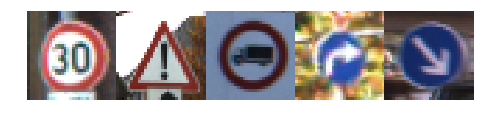

In [46]:

### Load the images and plot them here.
### Feel free to use as many code cells as needed.

#reading in an image
import glob
import matplotlib.image as mpimg

fig, axs = plt.subplots(1,5, figsize=(8, 4))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./GTSRB/*****.ppm')):
    image = cv2.imread(img)
    image = cv2.resize(image, (32, 32))
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    my_images.append(image)

my_images = np.asarray(my_images)

my_images_gry = np.sum(my_images/3, axis=3, keepdims=True)

my_images_normalized = (my_images_gry - 128)/128 

print(my_images_normalized.shape)

In [47]:
### The predictions here.
my_labels = [1, 18, 16, 33, 38]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('lenet_split.meta')
    saver3.restore(sess, "lenet_split")
    my_accuracy = evaluate(my_images_normalized, my_labels)
    print("Test Set Accuracy = {:.3f}".format(my_accuracy))

INFO:tensorflow:Restoring parameters from lenet_split
Test Set Accuracy = 1.000


INFO:tensorflow:Restoring parameters from lenet_split


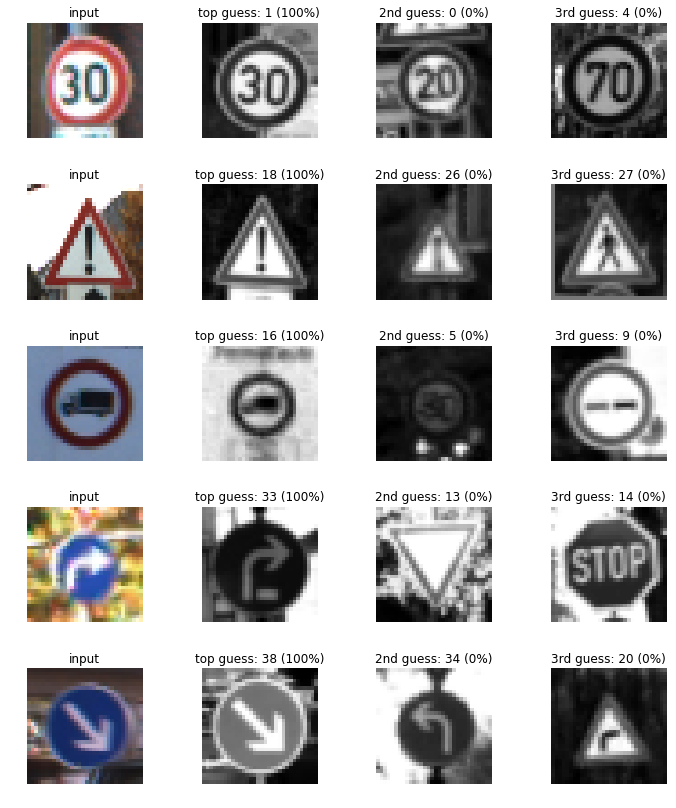

In [49]:
### Visualize the softmax probabilities here.

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('lenet_split.meta')
    saver.restore(sess, "lenet_split")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_images_normalized, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: my_images_normalized, keep_prob: 1.0})

    
    fig, axs = plt.subplots(len(my_images),4, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[4*i].axis('off')
        axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[4*i].set_title('input')
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_validation_split == guess1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_validation_split[index1].squeeze(), cmap='gray')
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_validation_split == guess2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_validation_split[index2].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_validation_split == guess3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_validation_split[index3].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))